# 2. Methods of simulation

In questa sezione descriviamo:
- le condizioni iniziali utilizzate,
- i metodi numerici di integrazione (RK4 a passo fisso e RK45 adattivo),
- le quantità diagnostiche che usiamo per valutare l’accuratezza (energia totale, errore, ecc.).


In [2]:

import numpy as np

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt


In [3]:
# 2.1 Equations of motion (3 corpi in 2D, G = 1)

def system_odes(t, s, m1, m2, m3):
    """
    Stato s = [x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,vx3,vy3]
    Ritorna ds/dt = [vx1,vy1,...,ax1,ay1,...].
    """

    # Posizioni
    r1 = s[0:2]
    r2 = s[2:4]
    r3 = s[4:6]

    # Velocità
    v1 = s[6:8]
    v2 = s[8:10]
    v3 = s[10:12]

    # Accelerazioni gravitazionali (G = 1)
    dv1_dt = m3*(r3 - r1)/np.linalg.norm(r3 - r1)**3 \
           + m2*(r2 - r1)/np.linalg.norm(r2 - r1)**3

    dv2_dt = m3*(r3 - r2)/np.linalg.norm(r3 - r2)**3 \
           + m1*(r1 - r2)/np.linalg.norm(r1 - r2)**3

    dv3_dt = m1*(r1 - r3)/np.linalg.norm(r1 - r3)**3 \
           + m2*(r2 - r3)/np.linalg.norm(r2 - r3)**3

    # Derivate delle posizioni = velocità, derivate delle velocità = accelerazioni
    return np.array([
        v1[0], v1[1],
        v2[0], v2[1],
        v3[0], v3[1],
        dv1_dt[0], dv1_dt[1],
        dv2_dt[0], dv2_dt[1],
        dv3_dt[0], dv3_dt[1]
    ])


# 2.2 Metodo RK4 a passo fisso

def rk4_step(t_n, y_n, k, m1, m2, m3):
    """
    Un singolo passo di Runge–Kutta del 4° ordine.
    """
    k1 = system_odes(t_n,         y_n,            m1, m2, m3)
    k2 = system_odes(t_n + k/2.0, y_n + k*k1/2.0, m1, m2, m3)
    k3 = system_odes(t_n + k/2.0, y_n + k*k2/2.0, m1, m2, m3)
    k4 = system_odes(t_n + k,     y_n + k*k3,     m1, m2, m3)

    y_next = y_n + (k/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return y_next


def rk4_integrate(t_span, y0, k, m1, m2, m3):
    """
    Integra il sistema con RK4 a passo fisso k sull'intervallo t_span.
    Ritorna: array dei tempi t_rk4 e degli stati sol_rk4.
    """
    t0, tf = t_span
    N = int((tf - t0) / k)

    t_values = np.zeros(N+1)
    y_values = np.zeros((N+1, len(y0)))

    t_values[0] = t0
    y_values[0] = y0

    t_n = t0
    y_n = y0

    for i in range(1, N+1):
        y_n = rk4_step(t_n, y_n, k, m1, m2, m3)
        t_n = t_n + k

        t_values[i] = t_n
        y_values[i] = y_n

    return t_values, y_values


## 2.1 Methods

Teoria di RK4

In [4]:
# Solve the ODE using RK4 
def rk4(t_n, v_n, k, m1, m2, m3):
    phi1 = system_odes(t_n, v_n, m1, m2, m3)
    phi2 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi1, m1, m2, m3)
    phi3 = system_odes(t_n + k/2.0, v_n + (k/2.0)*phi2, m1, m2, m3)
    phi4 = system_odes(t_n + k, v_n + k*phi3, m1, m2, m3)

    v_next = v_n + (k/6.0)*(phi1 + 2*phi2 + 2*phi3 + phi4)
    return v_next


def rk4_integrate(t_span, v0, k, m1, m2, m3):
    t0, tf = t_span
    N = int((tf - t0) / k)

    t_values = np.zeros(N+1)
    v_values = np.zeros((N+1, len(v0)))

    t_values[0] = t0
    v_values[0] = v0

    t_n = t0
    v_n = v0

    for i in range(1, N+1):
        v_n = rk4(t_n, v_n, k, m1, m2, m3)
        t_n = t_n + k

        t_values[i] = t_n
        v_values[i] = v_n

    return t_values, v_values



Add detail about using RK45

In [5]:
# 2.4 Helper per simulare uno scenario con RK4 e RK45

def simulate_three_body(masses, pos_list, vel_list,
                        t_span=(0.0, 40.0), k=0.01, n_eval=400):
    """
    masses: (m1, m2, m3)
    pos_list: [r1, r2, r3] con r_i = np.array([x_i, y_i])
    vel_list: [v1, v2, v3] con v_i = np.array([vx_i, vy_i])
    """

    m1, m2, m3 = masses

    init_cond = np.array(pos_list + vel_list).ravel()

    # RK4 a passo fisso
    t_rk4, sol_rk4 = rk4_integrate(t_span, init_cond, k, m1, m2, m3)

    # RK45 adattivo (solve_ivp)
    t_eval = np.linspace(t_span[0], t_span[1], n_eval)
    sol = solve_ivp(system_odes, t_span, init_cond,
                    t_eval=t_eval, args=(m1, m2, m3))

    return t_rk4, sol_rk4, sol.t, sol.y


## 2.2 Other validation methods

Aggiungere descrizione teorica 

In [6]:
def total_energy(x1,y1,v1x,v1y, x2,y2,v2x,v2y, x3,y3,v3x,v3y, m1,m2,m3):
    # kinetic energy
    K  = 0.5*m1*(v1x**2 + v1y**2)
    K += 0.5*m2*(v2x**2 + v2y**2)
    K += 0.5*m3*(v3x**2 + v3y**2)
    
    # distances
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    
    # potential energy (G = 1)
    U = - m1*m2/r12 - m1*m3/r13 - m2*m3/r23
    
    return K + U

## 2.3 Initial conditions

In [36]:


# Scenario base: triangolo equilatero, masse uguali

masses_base = (1.0, 1.0, 1.0)

pos_base = [
    np.array([ 1.0, 0.0]),
    np.array([-0.5,  np.sqrt(3)/2]),
    np.array([-0.5, -np.sqrt(3)/2])
]

omega = 0.8
# qui potresti usare le velocità "perfette" di rotazione rigida, ma teniamo le tue
vel_base = [
    np.array([ 0.0,        omega ]),
    np.array([ 0.7*omega, -0.35*omega]),
    np.array([-0.7*omega, -0.35*omega])
]

t_rk4_b, sol_rk4_b, t_rk45_b, sol_rk45_b = simulate_three_body(
    masses_base, pos_base, vel_base,
    t_span=(0.0, 20), k=0.01, n_eval=400
)


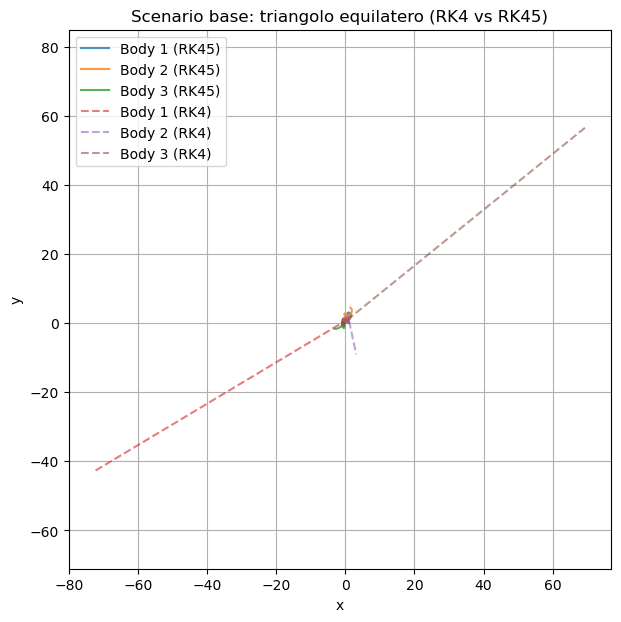

In [37]:
# Estrazione posizioni da RK4 e RK45
p1x_rk4_b = sol_rk4_b[:, 0]; p1y_rk4_b = sol_rk4_b[:, 1]
p2x_rk4_b = sol_rk4_b[:, 2]; p2y_rk4_b = sol_rk4_b[:, 3]
p3x_rk4_b = sol_rk4_b[:, 4]; p3y_rk4_b = sol_rk4_b[:, 5]

p1x_rk45_b = sol_rk45_b[0];  p1y_rk45_b = sol_rk45_b[1]
p2x_rk45_b = sol_rk45_b[2];  p2y_rk45_b = sol_rk45_b[3]
p3x_rk45_b = sol_rk45_b[4];  p3y_rk45_b = sol_rk45_b[5]

plt.figure(figsize=(7,7))

# RK45 (linea piena)
plt.plot(p1x_rk45_b, p1y_rk45_b, label="Body 1 (RK45)", alpha=0.8)
plt.plot(p2x_rk45_b, p2y_rk45_b, label="Body 2 (RK45)", alpha=0.8)
plt.plot(p3x_rk45_b, p3y_rk45_b, label="Body 3 (RK45)", alpha=0.8)

# RK4 (tratteggiato)
plt.plot(p1x_rk4_b, p1y_rk4_b, '--', alpha=0.6, label="Body 1 (RK4)")
plt.plot(p2x_rk4_b, p2y_rk4_b, '--', alpha=0.6, label="Body 2 (RK4)")
plt.plot(p3x_rk4_b, p3y_rk4_b, '--', alpha=0.6, label="Body 3 (RK4)")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Scenario base: triangolo equilatero (RK4 vs RK45)")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()


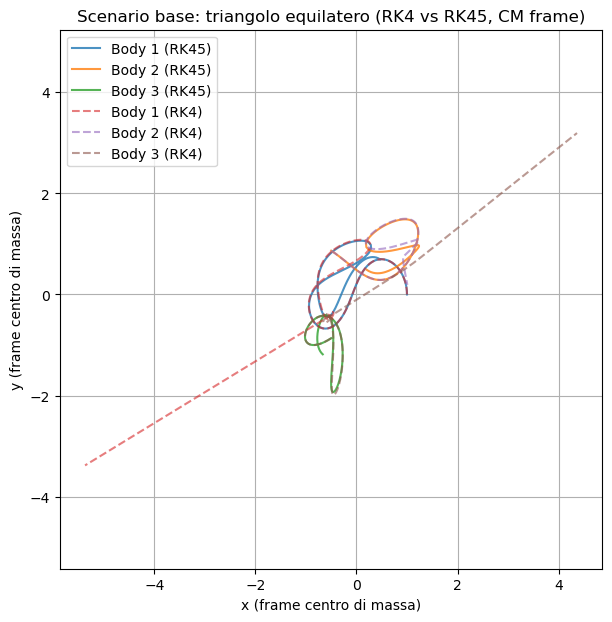

In [35]:
# Scenario base: triangolo equilatero, masse uguali

masses_base = (1.0, 1.0, 1.0)

pos_base = [
    np.array([ 1.0, 0.0]),
    np.array([-0.5,  np.sqrt(3)/2]),
    np.array([-0.5, -np.sqrt(3)/2])
]

omega = 0.8
# qui potresti usare le velocità "perfette" di rotazione rigida, ma teniamo le tue
vel_base = [
    np.array([ 0.0,        omega ]),
    np.array([ 0.7*omega, -0.35*omega]),
    np.array([-0.7*omega, -0.35*omega])
]

t_rk4_b, sol_rk4_b, t_rk45_b, sol_rk45_b = simulate_three_body(
    masses_base, pos_base, vel_base,
    t_span=(0.0, 10), k=0.01, n_eval=400
)

# Estrazione posizioni da RK4 e RK45
p1x_rk4_b = sol_rk4_b[:, 0]; p1y_rk4_b = sol_rk4_b[:, 1]
p2x_rk4_b = sol_rk4_b[:, 2]; p2y_rk4_b = sol_rk4_b[:, 3]
p3x_rk4_b = sol_rk4_b[:, 4]; p3y_rk4_b = sol_rk4_b[:, 5]

p1x_rk45_b = sol_rk45_b[0];  p1y_rk45_b = sol_rk45_b[1]
p2x_rk45_b = sol_rk45_b[2];  p2y_rk45_b = sol_rk45_b[3]
p3x_rk45_b = sol_rk45_b[4];  p3y_rk45_b = sol_rk45_b[5]

# ---------- NUOVO: spostiamo tutto nel sistema del centro di massa ----------

m1, m2, m3 = masses_base
M = m1 + m2 + m3

# Centro di massa per RK4
x_cm_rk4 = (m1*p1x_rk4_b + m2*p2x_rk4_b + m3*p3x_rk4_b) / M
y_cm_rk4 = (m1*p1y_rk4_b + m2*p2y_rk4_b + m3*p3y_rk4_b) / M

# Centro di massa per RK45
x_cm_rk45 = (m1*p1x_rk45_b + m2*p2x_rk45_b + m3*p3x_rk45_b) / M
y_cm_rk45 = (m1*p1y_rk45_b + m2*p2y_rk45_b + m3*p3y_rk45_b) / M

# Posizioni relative al centro di massa
p1x_rk4_rel  = p1x_rk4_b  - x_cm_rk4
p1y_rk4_rel  = p1y_rk4_b  - y_cm_rk4
p2x_rk4_rel  = p2x_rk4_b  - x_cm_rk4
p2y_rk4_rel  = p2y_rk4_b  - y_cm_rk4
p3x_rk4_rel  = p3x_rk4_b  - x_cm_rk4
p3y_rk4_rel  = p3y_rk4_b  - y_cm_rk4

p1x_rk45_rel = p1x_rk45_b - x_cm_rk45
p1y_rk45_rel = p1y_rk45_b - y_cm_rk45
p2x_rk45_rel = p2x_rk45_b - x_cm_rk45
p2y_rk45_rel = p2y_rk45_b - y_cm_rk45
p3x_rk45_rel = p3x_rk45_b - x_cm_rk45
p3y_rk45_rel = p3y_rk45_b - y_cm_rk45

# Per avere assi con unità "ragionevoli", prendiamo min/max delle posizioni relative
all_x = np.concatenate([p1x_rk45_rel, p2x_rk45_rel, p3x_rk45_rel,
                        p1x_rk4_rel,  p2x_rk4_rel,  p3x_rk4_rel])
all_y = np.concatenate([p1y_rk45_rel, p2y_rk45_rel, p3y_rk45_rel,
                        p1y_rk4_rel,  p2y_rk4_rel,  p3y_rk4_rel])

margin = 0.5  # piccolo margine attorno alle traiettorie
x_min, x_max = all_x.min() - margin, all_x.max() + margin
y_min, y_max = all_y.min() - margin, all_y.max() + margin

# ---------- PLOT nel frame del centro di massa ----------

plt.figure(figsize=(7,7))

# RK45 (linea piena)
plt.plot(p1x_rk45_rel, p1y_rk45_rel, label="Body 1 (RK45)", alpha=0.8)
plt.plot(p2x_rk45_rel, p2y_rk45_rel, label="Body 2 (RK45)", alpha=0.8)
plt.plot(p3x_rk45_rel, p3y_rk45_rel, label="Body 3 (RK45)", alpha=0.8)

# RK4 (tratteggiato)
plt.plot(p1x_rk4_rel, p1y_rk4_rel, '--', alpha=0.6, label="Body 1 (RK4)")
plt.plot(p2x_rk4_rel, p2y_rk4_rel, '--', alpha=0.6, label="Body 2 (RK4)")
plt.plot(p3x_rk4_rel, p3y_rk4_rel, '--', alpha=0.6, label="Body 3 (RK4)")

plt.xlabel("x (frame centro di massa)")
plt.ylabel("y (frame centro di massa)")
plt.title("Scenario base: triangolo equilatero (RK4 vs RK45, CM frame)")
plt.axis("equal")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend()
plt.show()


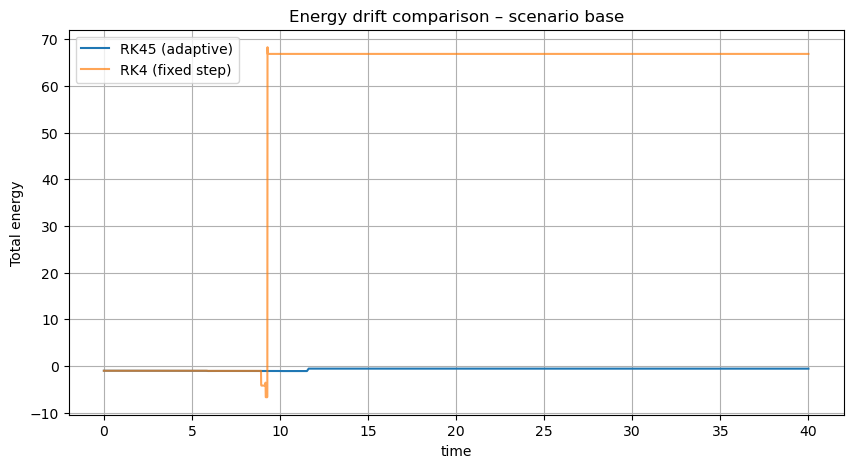

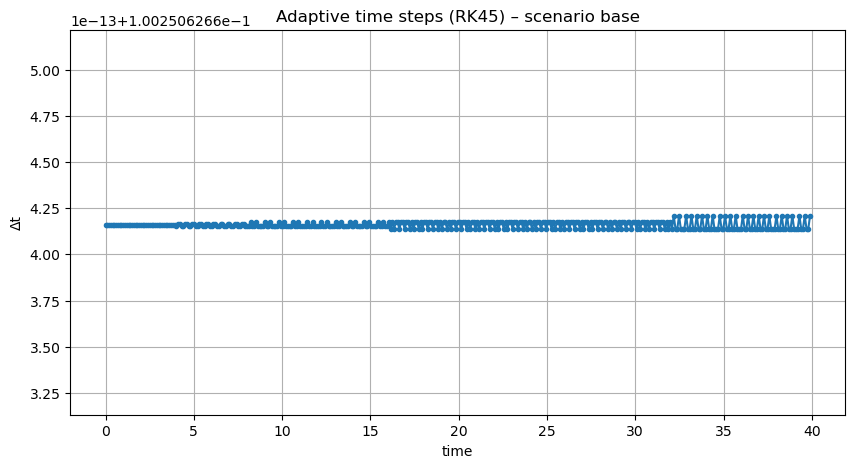

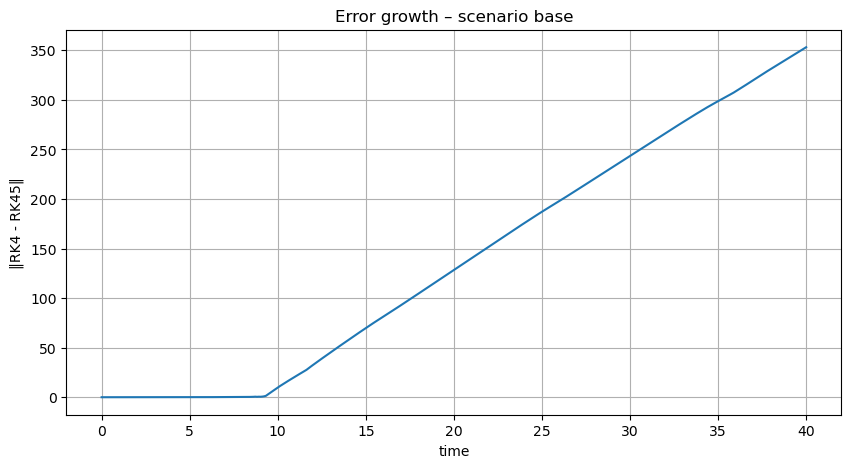

In [10]:
# 3.2 Energia nel tempo (scenario base)

# Energia RK45
E_rk45_b = np.array([
    total_energy(
        sol_rk45_b[0,i], sol_rk45_b[1,i], sol_rk45_b[6,i], sol_rk45_b[7,i],
        sol_rk45_b[2,i], sol_rk45_b[3,i], sol_rk45_b[8,i], sol_rk45_b[9,i],
        sol_rk45_b[4,i], sol_rk45_b[5,i], sol_rk45_b[10,i], sol_rk45_b[11,i],
        *masses_base
    )
    for i in range(sol_rk45_b.shape[1])
])

# Energia RK4
E_rk4_b = np.array([
    total_energy(
        sol_rk4_b[i,0], sol_rk4_b[i,1], sol_rk4_b[i,6], sol_rk4_b[i,7],
        sol_rk4_b[i,2], sol_rk4_b[i,3], sol_rk4_b[i,8], sol_rk4_b[i,9],
        sol_rk4_b[i,4], sol_rk4_b[i,5], sol_rk4_b[i,10], sol_rk4_b[i,11],
        *masses_base
    )
    for i in range(sol_rk4_b.shape[0])
])

plt.figure(figsize=(10,5))
plt.plot(t_rk45_b, E_rk45_b, label="RK45 (adaptive)")
plt.plot(t_rk4_b,  E_rk4_b,  label="RK4 (fixed step)", alpha=0.7)
plt.xlabel("time")
plt.ylabel("Total energy")
plt.title("Energy drift comparison – scenario base")
plt.grid(True)
plt.legend()
plt.show()


# 3.3 Passi adattivi RK45 (scenario base)

dt_rk45_b = np.diff(t_rk45_b)
plt.figure(figsize=(10,5))
plt.plot(t_rk45_b[:-1], dt_rk45_b, marker='o', markersize=3)
plt.xlabel("time")
plt.ylabel("Δt")
plt.title("Adaptive time steps (RK45) – scenario base")
plt.grid(True)
plt.show()


# 3.4 Errore RK4 vs RK45 (scenario base)

interp_rk4_b = interp1d(t_rk4_b, sol_rk4_b, axis=0, fill_value="extrapolate")
sol_rk4_interp_b = interp_rk4_b(t_rk45_b)

pos_rk45_b = sol_rk45_b[0:6,:].T      # (N, 6) = [x1,y1,x2,y2,x3,y3]
pos_rk4i_b = sol_rk4_interp_b[:, :6]  # (N, 6)

error_b = np.linalg.norm(pos_rk45_b - pos_rk4i_b, axis=1)

plt.figure(figsize=(10,5))
plt.plot(t_rk45_b, error_b)
plt.xlabel("time")
plt.ylabel("‖RK4 - RK45‖")
plt.title("Error growth – scenario base")
plt.grid(True)
plt.show()


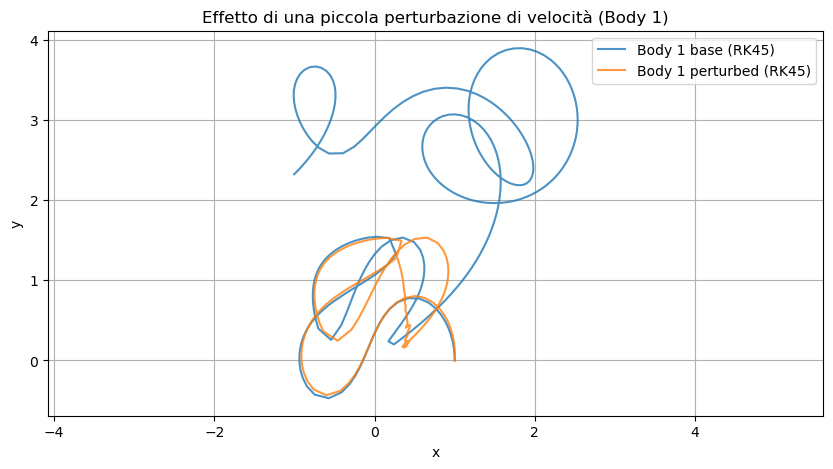

In [11]:
# 3.5 Scenario 2: piccola perturbazione della velocità di Body 1

delta_v = np.array([0.05, 0.0])  # piccola variazione sulla componente x

vel_perturbed = [
    vel_base[0] + delta_v,  # solo il primo corpo è perturbato
    vel_base[1],
    vel_base[2]
]

t_rk4_pv, sol_rk4_pv, t_rk45_pv, sol_rk45_pv = simulate_three_body(
    masses_base, pos_base, vel_perturbed,
    t_span=(0.0, 40.0), k=0.01, n_eval=400
)

# Grafico: confronto scenario base vs perturbato (solo RK45 per chiarezza)
plt.figure(figsize=(10,5))

# Body 1 base
plt.plot(p1x_rk45_b, p1y_rk45_b, label="Body 1 base (RK45)", alpha=0.8)
# Body 1 perturbato
plt.plot(sol_rk45_pv[0], sol_rk45_pv[1], label="Body 1 perturbed (RK45)", alpha=0.8)

plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.title("Effetto di una piccola perturbazione di velocità (Body 1)")
plt.legend()
plt.show()


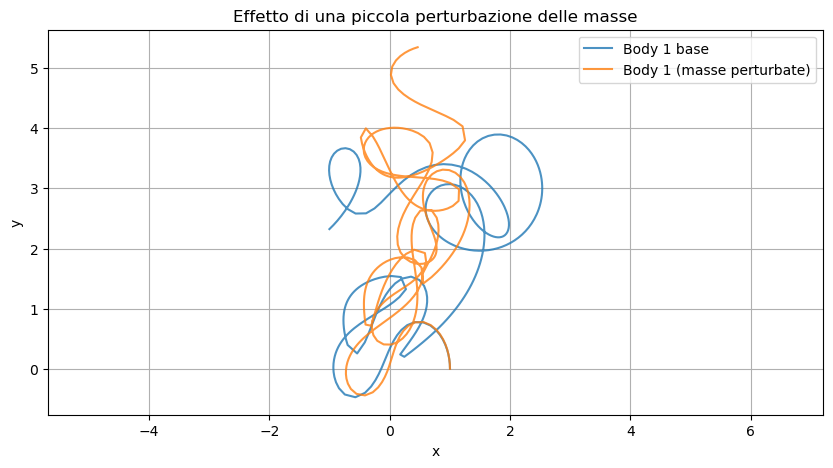

In [12]:
# 3.6 Scenario 3: piccola perturbazione delle masse

masses_pert = (1.1, 1.0, 0.9)  # leggero sbilanciamento

t_rk4_pm, sol_rk4_pm, t_rk45_pm, sol_rk45_pm = simulate_three_body(
    masses_pert, pos_base, vel_base,
    t_span=(0.0, 40.0), k=0.01, n_eval=400
)

plt.figure(figsize=(10,5))

# Body 1 base (RK45)
plt.plot(p1x_rk45_b, p1y_rk45_b, label="Body 1 base", alpha=0.8)
# Body 1 con masse perturbate
plt.plot(sol_rk45_pm[0], sol_rk45_pm[1], label="Body 1 (masse perturbate)", alpha=0.8)

plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.title("Effetto di una piccola perturbazione delle masse")
plt.legend()
plt.show()


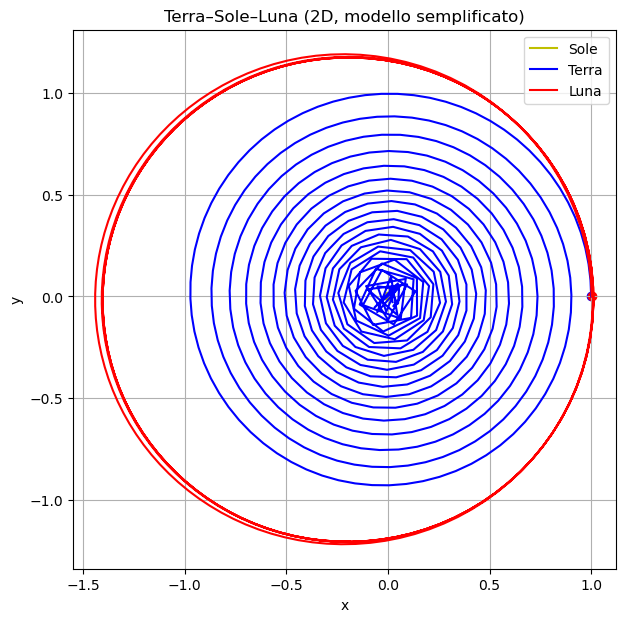

In [13]:
# 3.7 Scenario 4: Terra–Sole–Luna (2D, scalato)

m_sun   = 1.0
m_earth = 3.0e-6
m_moon  = 3.7e-8

masses_esl = (m_sun, m_earth, m_moon)

R_se = 1.0           # distanza Sole–Terra
R_em = 0.00257      # distanza Terra–Luna

# Posizioni: Sole all'origine, Terra sulla x positiva, Luna ancora più a destra
pos_esl = [
    np.array([0.0,          0.0]),          # Sole
    np.array([R_se,         0.0]),          # Terra
    np.array([R_se+R_em,    0.0])           # Luna
]

# Velocità approssimative per orbite quasi circolari (valori scelti a mano)
v_earth = np.array([0.0, 1.0])   # Terra verso +y
v_moon  = np.array([0.0, 1.1])   # Luna leggermente più veloce

vel_esl = [
    np.array([0.0, 0.0]),  # Sole quasi fermo
    v_earth,
    v_moon
]

t_rk4_esl, sol_rk4_esl, t_rk45_esl, sol_rk45_esl = simulate_three_body(
    masses_esl, pos_esl, vel_esl,
    t_span=(0.0, 40.0), k=0.005, n_eval=500
)

# Grafico traiettorie (solo RK45)
x_s, y_s = sol_rk45_esl[0], sol_rk45_esl[1]
x_e, y_e = sol_rk45_esl[2], sol_rk45_esl[3]
x_m, y_m = sol_rk45_esl[4], sol_rk45_esl[5]

plt.figure(figsize=(7,7))
plt.plot(x_s, y_s, 'y-', label="Sole")
plt.plot(x_e, y_e, 'b-', label="Terra")
plt.plot(x_m, y_m, 'r-', label="Luna")

plt.scatter(x_s[0], y_s[0], c='y')
plt.scatter(x_e[0], y_e[0], c='b')
plt.scatter(x_m[0], y_m[0], c='r')

plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.title("Terra–Sole–Luna (2D, modello semplificato)")
plt.legend()
plt.show()


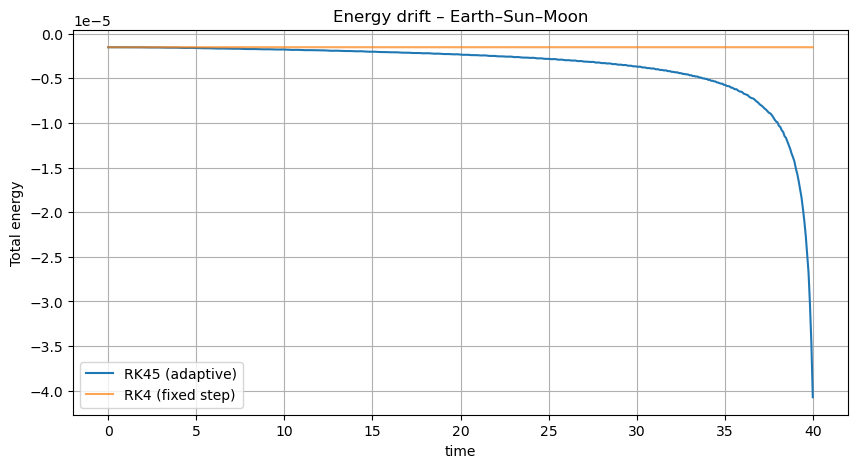

In [14]:
# Energia totale per RK45 (ESL)

E_rk45_esl = np.array([
    total_energy(
        sol_rk45_esl[0, i], sol_rk45_esl[1, i], sol_rk45_esl[6, i], sol_rk45_esl[7, i],
        sol_rk45_esl[2, i], sol_rk45_esl[3, i], sol_rk45_esl[8, i], sol_rk45_esl[9, i],
        sol_rk45_esl[4, i], sol_rk45_esl[5, i], sol_rk45_esl[10, i], sol_rk45_esl[11, i],
        *masses_esl
    )
    for i in range(sol_rk45_esl.shape[1])
])

# Energia totale per RK4 (ESL)

E_rk4_esl = np.array([
    total_energy(
        sol_rk4_esl[i, 0], sol_rk4_esl[i, 1], sol_rk4_esl[i, 6], sol_rk4_esl[i, 7],
        sol_rk4_esl[i, 2], sol_rk4_esl[i, 3], sol_rk4_esl[i, 8], sol_rk4_esl[i, 9],
        sol_rk4_esl[i, 4], sol_rk4_esl[i, 5], sol_rk4_esl[i,10], sol_rk4_esl[i,11],
        *masses_esl
    )
    for i in range(sol_rk4_esl.shape[0])
])

plt.figure(figsize=(10,5))
plt.plot(t_rk45_esl, E_rk45_esl, label="RK45 (adaptive)")
plt.plot(t_rk4_esl,  E_rk4_esl,  label="RK4 (fixed step)", alpha=0.7)

plt.xlabel("time")
plt.ylabel("Total energy")
plt.title("Energy drift – Earth–Sun–Moon")
plt.grid(True)
plt.legend()
plt.show()


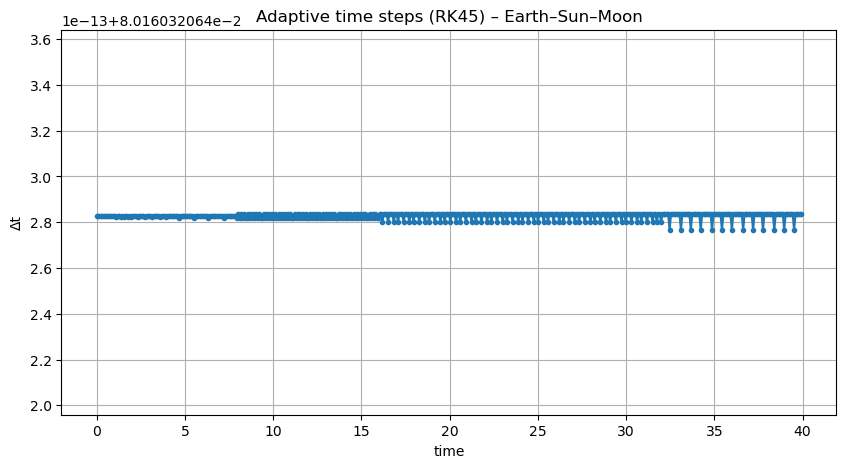

In [15]:
# Passi adattivi usati da RK45 nel caso ESL

dt_rk45_esl = np.diff(t_rk45_esl)

plt.figure(figsize=(10,5))
plt.plot(t_rk45_esl[:-1], dt_rk45_esl, marker='o', markersize=3)
plt.xlabel("time")
plt.ylabel("Δt")
plt.title("Adaptive time steps (RK45) – Earth–Sun–Moon")
plt.grid(True)
plt.show()


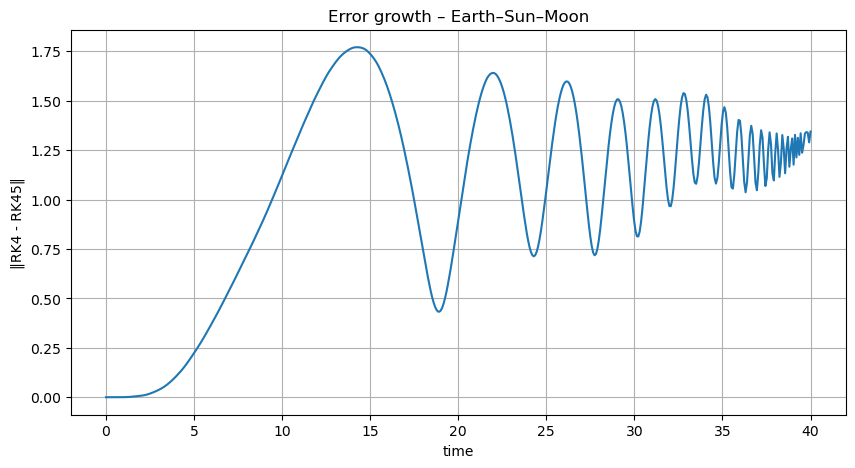

In [16]:
# Confronto RK4 vs RK45 per ESL: errore sulla posizione

# Interpolazione della soluzione RK4 sui tempi di RK45
interp_rk4_esl = interp1d(t_rk4_esl, sol_rk4_esl, axis=0, fill_value="extrapolate")
sol_rk4_interp_esl = interp_rk4_esl(t_rk45_esl)   # shape: (N_t, 12)

# Posizioni [x1,y1,x2,y2,x3,y3] da RK45 e RK4 interpolato
pos_rk45_esl = sol_rk45_esl[0:6, :].T          # (N, 6)
pos_rk4i_esl = sol_rk4_interp_esl[:, 0:6]      # (N, 6)

# Norma euclidea della differenza
error_esl = np.linalg.norm(pos_rk45_esl - pos_rk4i_esl, axis=1)

plt.figure(figsize=(10,5))
plt.plot(t_rk45_esl, error_esl)
plt.xlabel("time")
plt.ylabel("‖RK4 - RK45‖")
plt.title("Error growth – Earth–Sun–Moon")
plt.grid(True)
plt.show()


# 3. Analysis of trajectories and results

## 3.1 Numerical solutions

In [17]:
# Symmetric rotating triangle 

init_pos_1 = np.array([ 1.0, 0.0])
init_pos_2 = np.array([-0.5, np.sqrt(3)/2])
init_pos_3 = np.array([-0.5, -np.sqrt(3)/2])

# same mass
m1 = m2 = m3 = 1.0

# velocities for rigid body rotation
omega = 0.8
init_vel_1 = np.array([0,  omega])
init_vel_2 = np.array([0.7*omega, -0.35*omega])
init_vel_3 = np.array([-0.7*omega, -0.35*omega])

init_cond = np.array([
    init_pos_1, init_pos_2, init_pos_3,
    init_vel_1, init_vel_2, init_vel_3 
]).ravel()
#ravel to make it one dimensional to satisfy solve_ivp conditions
#init_cond needs to be an array as s variable in def system_odes also needs to be an array

In [18]:

time_s, time_e = 1, 40
k = 0.01
t_rk4, sol_rk4 = rk4_integrate((time_s, time_e), init_cond, k, m1, m2, m3)

p1x_rk4 = sol_rk4[:, 0]
p1y_rk4 = sol_rk4[:, 1]

p2x_rk4 = sol_rk4[:, 2]
p2y_rk4 = sol_rk4[:, 3]

p3x_rk4 = sol_rk4[:, 4]
p3y_rk4 = sol_rk4[:, 5]

v1x_rk4 = sol_rk4[:, 6]
v1y_rk4 = sol_rk4[:, 7]

v2x_rk4 = sol_rk4[:, 8]
v2y_rk4 = sol_rk4[:, 9]

v3x_rk4 = sol_rk4[:, 10]
v3y_rk4 = sol_rk4[:, 11]

In [19]:
t_points = np.linspace(time_s, time_e, 100)


solution = solve_ivp(
    fun=system_odes, #system of ODEs 
    t_span=(time_s, time_e), #time span
    y0= init_cond, #set initial conditions 
    t_eval = t_points, #array of times at which to store the computed solution
    args= (m1, m2, m3) #extra arguments, in our case are the masses
)

#from the solution we get the coordinates of the position
t_rk45 = solution.t

p1x_rk45 = solution.y[0]
p1y_rk45 = solution.y[1]

p2x_rk45 = solution.y[2]
p2y_rk45 = solution.y[3]

p3x_rk45 = solution.y[4]
p3y_rk45 = solution.y[5]

v1x_rk45 = solution.y[6]
v1y_rk45 = solution.y[7]

v2x_rk45 = solution.y[8]
v2y_rk45 = solution.y[9]

v3x_rk45 = solution.y[10]
v3y_rk45 = solution.y[11]



## 3.1 Trajectories 
### plot mass scenario 
- equal masses (already showing)
- one much larger mass (later)
- solar system style (later)

### plot numerical method comparison 
compare RK4 vs RK45 
- energy drift plot 
- Step size evolution of RK45 (adaptive method)

### Plot  Local Error? 
- position error 

## Trajectories of the Three Bodies (Combined RK4 RK45)

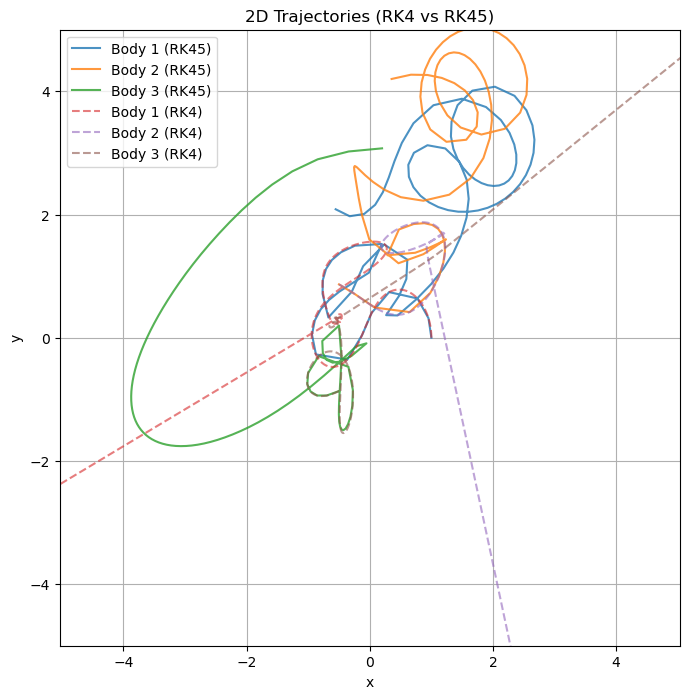

In [20]:
plt.figure(figsize=(8, 8))

# RK45 trajectories
plt.plot(p1x_rk45, p1y_rk45, label='Body 1 (RK45)', alpha=0.8)
plt.plot(p2x_rk45, p2y_rk45, label='Body 2 (RK45)', alpha=0.8)
plt.plot(p3x_rk45, p3y_rk45, label='Body 3 (RK45)', alpha=0.8)

# RK4 trajectories (dashed)
plt.plot(p1x_rk4, p1y_rk4, '--', label='Body 1 (RK4)', alpha=0.6)
plt.plot(p2x_rk4, p2y_rk4, '--', label='Body 2 (RK4)', alpha=0.6)
plt.plot(p3x_rk4, p3y_rk4, '--', label='Body 3 (RK4)', alpha=0.6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Trajectories (RK4 vs RK45)')
plt.legend()
plt.axis('equal')
plt.grid(True)

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.show()


Commento trajectories

## Energy Drift Comparison (RK4 vs RK45)

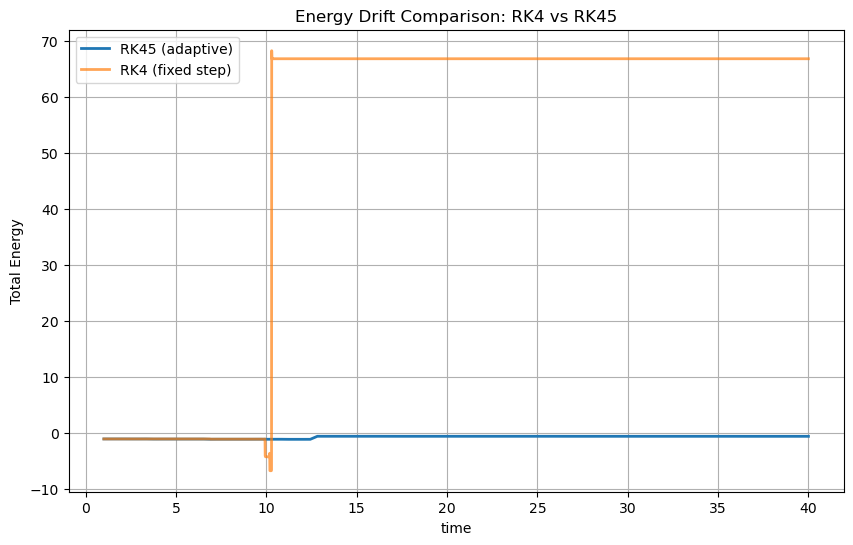

In [21]:


E_rk45 = np.array([
    total_energy(
        p1x_rk45[i], p1y_rk45[i], v1x_rk45[i], v1y_rk45[i],
        p2x_rk45[i], p2y_rk45[i], v2x_rk45[i], v2y_rk45[i],
        p3x_rk45[i], p3y_rk45[i], v3x_rk45[i], v3y_rk45[i],
        m1, m2, m3
    )
    for i in range(len(t_rk45))
])

E_rk4 = np.array([
    total_energy(
        sol_rk4[i,0], sol_rk4[i,1], sol_rk4[i,6], sol_rk4[i,7],
        sol_rk4[i,2], sol_rk4[i,3], sol_rk4[i,8], sol_rk4[i,9],
        sol_rk4[i,4], sol_rk4[i,5], sol_rk4[i,10], sol_rk4[i,11],
        m1, m2, m3
    )
    for i in range(len(t_rk4))
])

plt.figure(figsize=(10, 6))

plt.plot(t_rk45, E_rk45, label='RK45 (adaptive)', linewidth=2)
plt.plot(t_rk4,  E_rk4,  label='RK4 (fixed step)', linewidth=2, alpha=0.7)

plt.xlabel('time')
plt.ylabel('Total Energy')
plt.title('Energy Drift Comparison: RK4 vs RK45')
plt.legend()
plt.grid(True)
plt.show()




quale metodo conserva meglio l’energia, se c’è drift

## Adaptive Time Steps of RK45

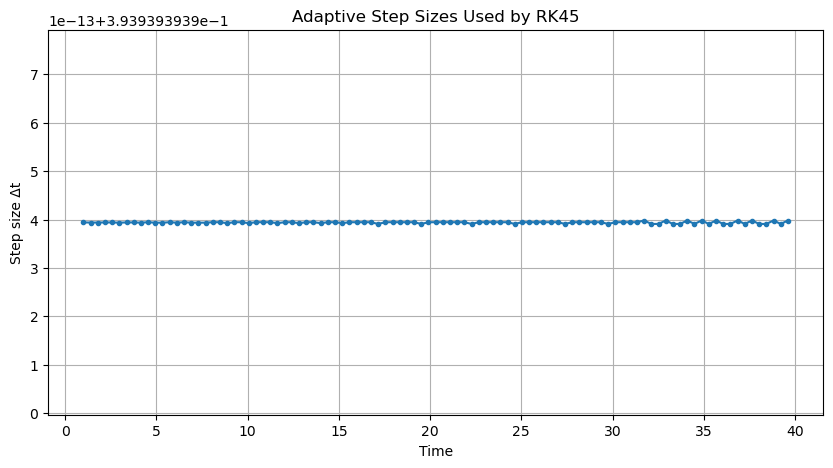

In [22]:
# Adaptive time steps of RK45
dt_rk45 = np.diff(t_rk45)

plt.figure(figsize=(10,5))
plt.plot(t_rk45[:-1], dt_rk45, marker='o', markersize=3)

plt.xlabel("Time")
plt.ylabel("Step size Δt")
plt.title("Adaptive Step Sizes Used by RK45")
plt.grid(True)
plt.show()


dove il moto è più complesso il passo diminuisce

## Error Growth: RK4 vs RK45

In [23]:
# Interpolate RK4 (sol_rk4) onto RK45 time points for comparison
from scipy.interpolate import interp1d

interp_rk4 = interp1d(t_rk4, sol_rk4, axis=0, fill_value="extrapolate")
sol_rk4_interp = interp_rk4(t_rk45)


In [24]:
# Positions from RK45
pos_rk45 = np.vstack([
    p1x_rk45, p1y_rk45,
    p2x_rk45, p2y_rk45,
    p3x_rk45, p3y_rk45
]).T  # shape (N, 6)

# Positions from interpolated RK4
pos_rk4i = sol_rk4_interp[:, :6]

# Euclidean position error
error = np.linalg.norm(pos_rk45 - pos_rk4i, axis=1)


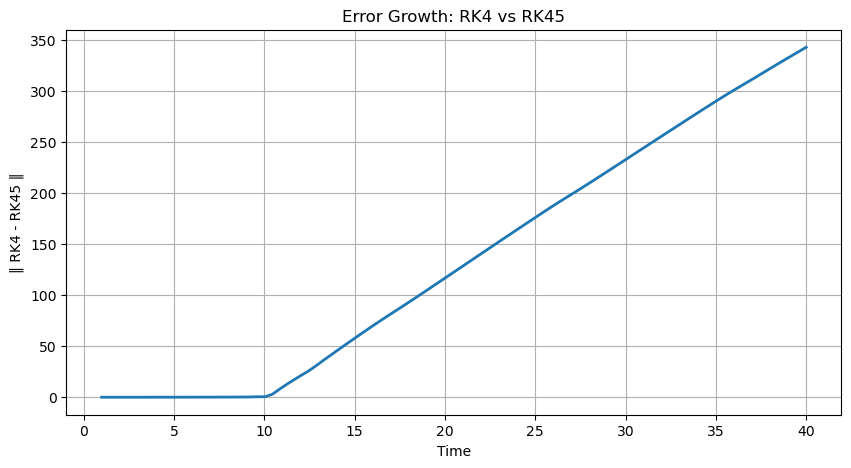

In [25]:
plt.figure(figsize=(10,5))
plt.plot(t_rk45, error, linewidth=2)

plt.xlabel("Time")
plt.ylabel("‖ RK4 - RK45 ‖")
plt.title("Error Growth: RK4 vs RK45")
plt.grid(True)
plt.show()


E qui discuti che l’errore cresce nel tempo

Now we analyse how different initial conditions change behaviour

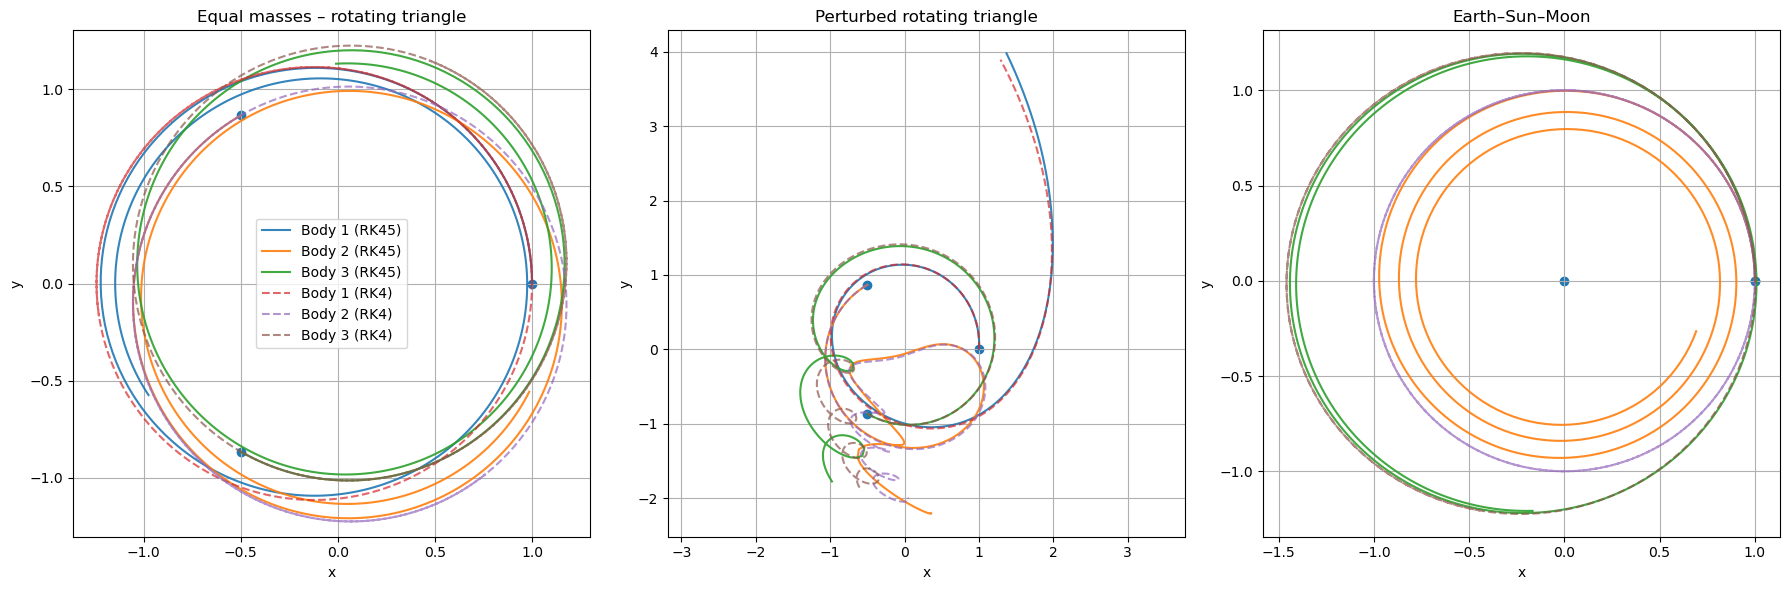

In [ ]:
omega = 0.8

# 1) Equal masses – rotating triangle
# posizioni: triangolo equilatero di lato 2
pos_eq = [
    np.array([ 1.0, 0.0]),
    np.array([-0.5,  np.sqrt(3)/2]),
    np.array([-0.5, -np.sqrt(3)/2])
]

# velocità per rotazione rigida: v = ω * (-y, x)
vel_eq = [
    np.array([-0.0 * omega,  1.0 * omega]),                    # [0, ω]
    np.array([-(np.sqrt(3)/2)*omega, -0.5 * omega]),           # corpo 2
    np.array([+(np.sqrt(3)/2)*omega, -0.5 * omega])            # corpo 3
]

masses_eq = (1.0, 1.0, 1.0)

# 2) Perturbation of rotating triangle
delta_v = np.array([0.05, 0.0])  # piccola perturbazione sulla vx del corpo 1

vel_eq_pert = [
    vel_eq[0] + delta_v,   # solo il corpo 1 perturbato
    vel_eq[1],
    vel_eq[2]
]

# 3) Earth–Sun–Moon (scalato, 2D)
m_sun   = 1.0
m_earth = 3.0e-6
m_moon  = 3.7e-8

masses_esl = (m_sun, m_earth, m_moon)

R_se = 1.0        # distanza Sole–Terra
R_em = 0.00257    # distanza Terra–Luna

pos_esl = [
    np.array([0.0,       0.0]),        # Sole
    np.array([R_se,      0.0]),        # Terra
    np.array([R_se+R_em, 0.0])         # Luna
]

# velocità approssimative per orbite quasi circolari
v_earth = np.array([0.0, 1.0])
v_moon  = np.array([0.0, 1.1])

vel_esl = [
    np.array([0.0, 0.0]),  # Sole quasi fermo
    v_earth,
    v_moon
]

# ----------------- SCENARI -----------------

scenarios = [
    {
        "name":   "Equal masses – rotating triangle",
        "masses": masses_eq,
        "pos":    pos_eq,
        "vel":    vel_eq
    },
    {
        "name":   "Perturbed rotating triangle",
        "masses": masses_eq,
        "pos":    pos_eq,
        "vel":    vel_eq_pert
    },
    {
        "name":   "Earth–Sun–Moon",
        "masses": masses_esl,
        "pos":    pos_esl,
        "vel":    vel_esl
    }
]

fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for ax, sc in zip(axes, scenarios):
    masses   = sc["masses"]
    pos_list = sc["pos"]
    vel_list = sc["vel"]

    # usa la tua simulate_three_body(masses, pos_list, vel_list, ...)
    t_rk4, sol_rk4, t_rk45, y_rk45 = simulate_three_body(
        masses, pos_list, vel_list,
        t_span=(0, 15), k=0.01, n_eval=400
    )

    # ----- RK45 (soluzione adattiva) -----
    x1_45, y1_45 = y_rk45[0], y_rk45[1]
    x2_45, y2_45 = y_rk45[2], y_rk45[3]
    x3_45, y3_45 = y_rk45[4], y_rk45[5]

    # ----- RK4 (passo fisso) -----
    x1_4, y1_4 = sol_rk4[:, 0], sol_rk4[:, 1]
    x2_4, y2_4 = sol_rk4[:, 2], sol_rk4[:, 3]
    x3_4, y3_4 = sol_rk4[:, 4], sol_rk4[:, 5]

    # RK45: linee piene
    ax.plot(x1_45, y1_45, label="Body 1 (RK45)", alpha=0.9)
    ax.plot(x2_45, y2_45, label="Body 2 (RK45)", alpha=0.9)
    ax.plot(x3_45, y3_45, label="Body 3 (RK45)", alpha=0.9)

    # RK4: linee tratteggiate
    ax.plot(x1_4, y1_4, "--", label="Body 1 (RK4)", alpha=0.7)
    ax.plot(x2_4, y2_4, "--", label="Body 2 (RK4)", alpha=0.7)
    ax.plot(x3_4, y3_4, "--", label="Body 3 (RK4)", alpha=0.7)

    # punti iniziali (da RK45)
    ax.scatter([x1_45[0], x2_45[0], x3_45[0]],
               [y1_45[0], y2_45[0], y3_45[0]],
               marker='o')

    ax.set_title(sc["name"])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis("equal")
    ax.grid(True)

# legenda solo nel primo pannello
axes[0].legend()
plt.tight_layout()
plt.show()
